<a href="https://colab.research.google.com/github/ShreyBana/DCGAN/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython import display
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import glob
import os
import time

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()
MEAN = 127.5
train_images = (train_images - MEAN) / MEAN

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 256)))
    assert model.output_shape == (None, 4, 4, 256) # None is the batch size, assert for assurance of output shape

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [ ]:
discriminator = make_discriminator_model()
generator = make_generator_model()
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

In [ ]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              409600    
_________________________________________________________________
batch_normalization_3 (Batch (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)        

In [ ]:
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         8

In [ ]:
def generate_image():
    noise = tf.random.normal([1, 100])
    sample = generator(noise, training=False)
    plt.imshow(np.rint(sample[0]*MEAN + MEAN).astype(int))

    return sample

def get_prediction(image):
    out = discriminator(image, training=False)

    return out.numpy()

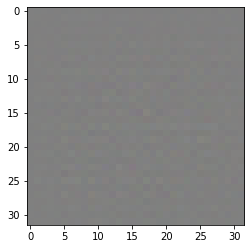

In [ ]:
sample0 = generate_image()

In [ ]:
prediction = get_prediction(sample0)
print(prediction[0])

[0.5001273]


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output): # outputs of discriminator
    shape = list(fake_output.shape)
    return cross_entropy(tf.random.uniform(shape, 0.7, 1.0), fake_output)

def discriminator_loss(real_output, fake_output):
    shape_r = list(real_output.shape)
    shape_f = list(fake_output.shape)
    real_loss = cross_entropy(tf.random.uniform(shape_r, 0.7, 1.0), real_output)
    fake_loss = cross_entropy(tf.random.uniform(shape_f, 0, 0.3), fake_output)
    return real_loss + fake_loss

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 50
NOISE_SIZE = 100
EXAMPLES = 16
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
SEED = tf.random.normal([EXAMPLES, NOISE_SIZE])

In [ ]:
@tf.function
def train_step(images):
    noise_fake = tf.random.normal([BATCH_SIZE, NOISE_SIZE])
    noise_real = tf.random.normal(list(images.shape), 0, 0.0001, tf.float64)
    images = tf.math.add(images, noise_real)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise_fake, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
def train(Dataset, Epochs):
    gen_loss, disc_loss = [], []
    for epoch in range(Epochs):
        start = time.time()
        gl, dl = 0, 0

        for batch in Dataset:
            temp1, temp2 = train_step(batch)
            gl += temp1
            dl += temp2
        
        gl = np.mean(gl)
        dl = np.mean(dl)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, SEED)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
        print('Generator loss: {}'.format(gl))
        print('Discriminator loss: {}'.format(dl))
           
        gen_loss.append(gl)
        disc_loss.append(dl)

    display.clear_output(wait=True)
    generate_and_save_images(generator, Epochs, SEED)

    return gen_loss, disc_loss

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(np.rint((predictions[i] * MEAN) + MEAN).astype(int), cmap=plt.cm.binary)
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

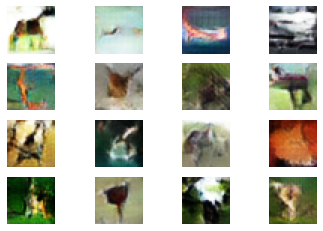

In [ ]:
gen_loss, disc_loss = train(train_dataset, EPOCHS)

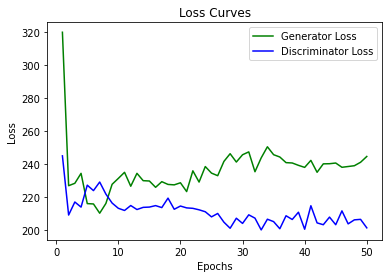

In [ ]:
epochs = range(1, EPOCHS + 1)
plt.plot(epochs, gen_loss, 'g', label='Generator Loss')
plt.plot(epochs, disc_loss, 'b', label='Discriminator Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()